# Fine-Tune a Model with Hugging Face's `Trainer` API

* Loosely derived from: https://huggingface.co/docs/transformers/tasks/sequence_classification
* Train, evaluate, output metrics

### `pip install` necessary packages, then restart runtime.

In [1]:
# uncomment lines below, run this cell, then restart the runtime before continuing
# !pip install transformers > out1
# !pip install datasets > out2
# !pip install numpy==1.23.4 > out3
# !pip install sentencepiece > out4

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import re
import scipy
import time
import torch

from datasets import load_dataset, Dataset
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification, pipeline, AutoConfig

### Verify if a GPU is available; print some details

In [3]:
print(f'Is a GPU available? {torch.cuda.is_available()}')
device_count = torch.cuda.device_count()
print(f'Number of GPUs available: {device_count}')
print(f'Current GPU index: {torch.cuda.current_device()}')
for i in range(device_count):
    print(f'Device {i}:')
    print(f'\t{torch.cuda.device(i)}')
    print(f'\t{torch.cuda.get_device_name(i)}')

Is a GPU available? True
Number of GPUs available: 2
Current GPU index: 0
Device 0:
	TITAN RTX
Device 1:
	TITAN RTX


In [4]:
!nvidia-smi

Wed Apr 19 04:27:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           On   | 00000000:21:00.0 Off |                  N/A |
| 41%   31C    P8    15W / 280W |   5939MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           On   | 00000000:42:00.0 Off |                  N/A |
| 41%   

### Load model and dataset

In [5]:
# label2id: maps the class names to integers.
# id2label: maps the integers to class names.
id2label = {0:"NEGATIVE", 1:"POSITIVE"}
label2id = {"NEGATIVE":0, "POSITIVE":1}

# load pre-trained BERT embeddings and associated tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',id2label = id2label, label2id=label2id)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [33]:
rt = load_dataset('rotten_tomatoes')
rt

Found cached dataset rotten_tomatoes (/home/dspuser/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

Examine a negative and a positive example from the `rotten_tomatoes` dataset

In [36]:
# positive review:
print(rt['train'][0])
print()
# negative review:
print(rt['train'][-7])

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}

{'text': "snoots will no doubt rally to its cause , trotting out threadbare standbys like 'masterpiece' and 'triumph' and all that malarkey , but rarely does an established filmmaker so ardently waste viewers' time with a gobbler like this .", 'label': 0}


#### Tokenize dataset

In [7]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_dataset, val_dataset, test_dataset = load_dataset('rotten_tomatoes', split=['train', 'validation', 'test'])
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
val_dataset = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Found cached dataset rotten_tomatoes (/home/dspuser/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/dspuser/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-c6f2004ca74c8270.arrow
Loading cached processed dataset at /home/dspuser/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-f9f7f7a097480819.arrow


Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

### Train your model
* Set up a function to compute metrics: accuracy, precision, recall, f1
* Define training arguments and instantiate `Trainer`

In [8]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    do_eval=True,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [9]:
# trainer.args

#### Evaluate model before fine-tuning.

In [10]:
test_zeroshot = trainer.predict(test_dataset=test_dataset)

/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [11]:
np.count_nonzero(test_zeroshot.predictions.argmax(-1))

1060

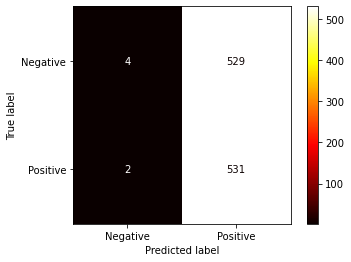

In [12]:
preds_zeroshot = test_zeroshot.predictions.argmax(-1)
actual_zeroshot = test_zeroshot.label_ids

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
# tn, fp, fn, tp
confusion_matrix_zeroshot = metrics.confusion_matrix(actual_zeroshot, preds_zeroshot)

cm_display_zeroshot = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_zeroshot, display_labels = ["Negative", "Positive"])

# Choose different colors: https://matplotlib.org/stable/tutorials/colors/colormaps.html
cm_display_zeroshot.plot(cmap='hot')
# cm_display.plot(cmap='inferno')
# cm_display.plot(cmap='gray')
# cm_display.plot(cmap='Reds')
# cm_display.plot(cmap='binary')
# cm_display.plot(cmap='flag')
plt.show()

#### Training Loop

In [13]:
# 8530 training examples
# 8530/16 -> np.ceil -> 534 -> 534 * 3 epochs = 1602 steps total.
# 8530/8 -> np.ceil -> 3201 -> 3201 * 3 epochs = 3201 steps total.
trainer.train()

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.398200
1000,0.195400
1500,0.080300


/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=1602, training_loss=0.21521386760897404, metrics={'train_runtime': 306.67, 'train_samples_per_second': 83.445, 'train_steps_per_second': 5.224, 'total_flos': 1025732282655600.0, 'train_loss': 0.21521386760897404, 'epoch': 3.0})

#### Save your model

In [14]:
dtg_save = time.strftime(f'%d%H%M%b%y').upper() #ex. '112036OCT21' ... add spaces for readability if desired
output_model = f"rot_tom_finetuned_model_{dtg_save}"
# model.save_pretrained(output_model)
trainer.save_model(output_model)

### Test your model

In [15]:
test_out = trainer.predict(test_dataset=test_dataset)

**Examine the elements of your test output**

In [16]:
test_out

PredictionOutput(predictions=array([[-3.5892618,  3.931948 ],
       [-3.787362 ,  3.9943578],
       [ 2.9288979, -2.3081646],
       ...,
       [ 3.2776308, -2.8021777],
       [ 3.5015411, -3.0222712],
       [ 3.2122035, -2.9123302]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0]), metrics={'test_loss': 0.729043185710907, 'test_accuracy': 0.8555347091932458, 'test_f1': 0.8555347091932458, 'test_precision': 0.8555347091932458, 'test_recall': 0.8555347091932458, 'test_runtime': 4.4104, 'test_samples_per_second': 241.699, 'test_steps_per_second': 15.191})

**Verify the number of positive/negative predictions**

In [17]:
test_out.predictions.argmax(-1)

array([1, 1, 0, ..., 0, 0, 0])

In [18]:
# Count all _predicted_ "Positive" classifications
np.count_nonzero(test_out.predictions.argmax(-1))

533

**Make a confusion matrix**

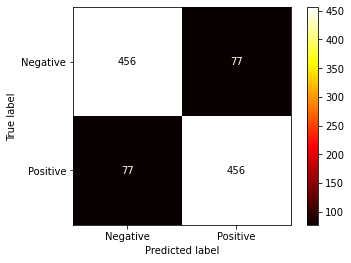

In [19]:
# https://en.wikipedia.org/wiki/Confusion_matrix

# Our plot shows:
# True Negative, False Positive
# False Negative, True Positive

# https://www.w3schools.com/python/python_ml_confusion_matrix.asp

preds = test_out.predictions.argmax(-1)
actual = test_out.label_ids

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
# tn, fp, fn, tp
results_confusion_matrix = metrics.confusion_matrix(actual, preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=results_confusion_matrix, display_labels = ["Negative", "Positive"])

# Choose different colors: https://matplotlib.org/stable/tutorials/colors/colormaps.html
cm_display.plot(cmap='hot')
# cm_display.plot(cmap='inferno')
# cm_display.plot(cmap='gray')
# cm_display.plot(cmap='Reds')
# cm_display.plot(cmap='binary')
# cm_display.plot(cmap='flag')
plt.show()

**Examine misclassified examples**

In [20]:
# create array of indices in test_dataset where examples were misclassified
# sum of any misclassified example in a binary classification == 1
misclassified = np.argwhere((actual+preds)==1).reshape(-1)
print(misclassified[:4],misclassified[-1:-5:-1])

print('Positive misclassified as negative:')
print('===================================')
for i,ex in enumerate(np.concatenate((misclassified[:4],misclassified[-1:-5:-1]))):
    if i == 4: 
        print('\nNegative misclassified as positive:')
        print('===================================\n')
    print(rt['test'][int(ex)]) # cast np.int64 as int

[ 2  7 14 21] [1059 1039 1037 1029]
Positive misclassified as negative:
{'text': 'it\'s like a " big chill " reunion of the baader-meinhof gang , only these guys are more harmless pranksters than political activists .', 'label': 1}
{'text': 'weighty and ponderous but every bit as filling as the treat of the title .', 'label': 1}
{'text': 'at its worst , the movie is pretty diverting ; the pity is that it rarely achieves its best .', 'label': 1}
{'text': "making such a tragedy the backdrop to a love story risks trivializing it , though chouraqui no doubt intended the film to affirm love's power to help people endure almost unimaginable horror .", 'label': 1}

Negative misclassified as positive:

{'text': "his [nelson's] screenplay needs some serious re-working to show more of the dilemma , rather than have his characters stage shouting matches about it .", 'label': 0}
{'text': "a film that plays things so nice 'n safe as to often play like a milquetoast movie of the week blown up for th

**Test saved model**

In [21]:
load_model_path = output_model #TODO change if you have a different model to load
model2 = BertForSequenceClassification.from_pretrained(load_model_path)

trainer2 = Trainer(
    model=model2,    # ONLY PARAMETER CHANGED WAS THE MODEL.  IT WILL NOW USE THE MODEL FINE-TUNED ON ROTTEN TOMATOES
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [22]:
test_out2 = trainer2.predict(test_dataset=test_dataset)
print(test_out2)

PredictionOutput(predictions=array([[-3.5892618,  3.931948 ],
       [-3.787362 ,  3.9943578],
       [ 2.9288979, -2.3081646],
       ...,
       [ 3.2776308, -2.8021777],
       [ 3.5015411, -3.0222712],
       [ 3.2122035, -2.9123302]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0]), metrics={'test_loss': 0.729043185710907, 'test_accuracy': 0.8555347091932458, 'test_f1': 0.8555347091932458, 'test_precision': 0.8555347091932458, 'test_recall': 0.8555347091932458, 'test_runtime': 4.2581, 'test_samples_per_second': 250.349, 'test_steps_per_second': 15.735})


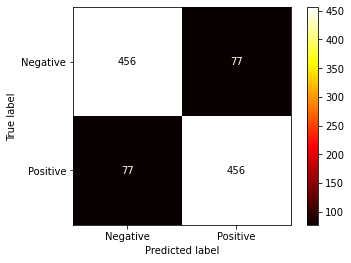

In [23]:
preds = test_out2.predictions.argmax(-1)
actual = test_out2.label_ids

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
# tn, fp, fn, tp
results_confusion_matrix = metrics.confusion_matrix(actual, preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=results_confusion_matrix, display_labels = ["Negative", "Positive"])

# Choose different colors: https://matplotlib.org/stable/tutorials/colors/colormaps.html
cm_display.plot(cmap='hot')
plt.show()

**Discussion of logits vs. softmax**  
[(https://huggingface.co/course/chapter2/2?fw=tf#postprocessing-the-output)

In [24]:
# https://huggingface.co/course/chapter2/2?fw=tf#postprocessing-the-output
# alternatively use softmax before argmax, since 'logits' are "the raw, unnormalized scores outputted by the last layer of the model"
#    Additional notes:
#         "all 🤗 Transformers models output the logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, 
#         with the actual loss function, such as cross entropy"

In [25]:
scipy.special.softmax(test_out2.predictions, axis = -1)

array([[5.4118416e-04, 9.9945891e-01],
       [4.1711988e-04, 9.9958283e-01],
       [9.9471235e-01, 5.2877422e-03],
       ...,
       [9.9771661e-01, 2.2833899e-03],
       [9.9853408e-01, 1.4659100e-03],
       [9.9781632e-01, 2.1837330e-03]], dtype=float32)

In [26]:
test_out2.predictions

array([[-3.5892618,  3.931948 ],
       [-3.787362 ,  3.9943578],
       [ 2.9288979, -2.3081646],
       ...,
       [ 3.2776308, -2.8021777],
       [ 3.5015411, -3.0222712],
       [ 3.2122035, -2.9123302]], dtype=float32)

In [27]:
test_out2.predictions.argmax(-1)

array([1, 1, 0, ..., 0, 0, 0])

### Test new data classification

In [28]:
MODEL_PATH = output_model
model3 = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
config3 = AutoConfig.from_pretrained(MODEL_PATH)

In [29]:
new_text = 'This movie makes my eyeballs ache and my ears bleed.'
# new_text = 'I truly found my happy place while consuming this film.'
new_text = tokenizer(new_text, truncation=True, padding=True, return_tensors='pt')

In [30]:
with torch.no_grad():
    logits = model3(**new_text).logits

In [31]:
logits.softmax(dim=-1).flatten()

tensor([0.9988, 0.0012])

In [32]:
for i,prob in enumerate(logits.softmax(dim=-1).flatten()):
    print(f'* {config3.id2label[i].capitalize()}: {np.round(prob.item()*100,3)} %')

* Negative: 99.884 %
* Positive: 0.116 %
